# **Evaluación de Métodos de Segmentación de Imágenes**

En este trabajo, creado con fines educativos, se implementarán y compararán 3 métodos clásicos de segmentación de imágenes, que son el *Thresholding*, la *Detección de Canny* y el *Clustering* (K-means), utilizando Python. Además, se desarrollarán implementaciones propias de los métodos Region Growth y Umbral Adaptativo Manual. Al final, se evaluará su desempeño y los resultados se compararán con imágenes reales (etiquetas manuales).

La técnica de segmentación de imágenes es muy utilizada para aplicaciones donde se quiere identificar objetos en la imagen, que pueden ser personas, coches, animales, etc. Es un trabajo que se realiza en la fase de preprocesamiento, es decir, procesar imágenes (datos) antes de enviarlas a un modelo de Machine Learning para realizar su trabajo que, en este caso, puede ser un caso clásico de identificación de objetos.

Disponible en [Google Colab](https://colab.research.google.com/drive/1k0QS03yhcrzVA-CheZnWORa3ELh6wltc#scrollTo=oD224CrdzT3Y) y [GitHub](https://github.com/edprata/data-labs/blob/231153273f6ff88c3e5ea7c127803e5f39796ca0/notebooks/M%C3%A9todos_de_Segmentaci%C3%B3n_de_Im%C3%A1genes.ipynb)

.

---

## **1. Métodos de Segmentación a Implementar**

### A) Segmentación por Umbralización (Thresholding con Otsu)

- Técnica simple basada en un umbral de intensidad.
- Divide la imagen en regiones basadas en un valor de intensidad (umbral).
- Simple pero efectivo para imágenes con alto contraste.
- Usaremos **Otsu's method** para selección automática del umbral.

### B) Detección de Canny

- Su objetivo es identificar bordes en imágenes con alta precisión.
- Suavizado: Aplica un filtro Gaussiano para reducir el ruido en la imagen.
- Cálculo de Gradientes: Detecta la intensidad y dirección de los bordes usando operadores (Sobel/Prewitt).
- Supresión de No Máximos: Afina los bordes conservando solo los píxeles con la magnitud máxima en la dirección del gradiente.
- Umbralización con Histéresis: Usa dos umbrales (threshold_min y threshold_max).

### C) Segmentación por Clustering (K-means)

- Agrupa píxeles en *k* clusters basados en similitud de color/intensidad.
- No requiere conocimiento previo de la imagen.
- Aplicaremos K-means en el espacio de color RGB.

### D) Region Growth (implementación própria)

Intetaremos una implementación própria de un método de segmentación basado en crecimiento de regiones (Region Growing):

- Ideal para imágenes donde los objetos tienen una textura o intensidad homogénea.
- Comienza desde una "semilla" (píxel inicial) y expande la región agregando píxeles vecinos similares.
- Ventaja: No requiere umbralización global ni clustering.

### E) Umbral Adaptativo (implementación propria)

También se incluye una implementación manual del método de Umbralización Adaptativa:

- En lugar de aplicar un único umbral global, se calcula un umbral local para cada píxel, considerando la media de intensidad de su vecindad.
- Este enfoque permite segmentar imágenes con iluminación no uniforme, donde el contraste varía en diferentes zonas.
- Para cada píxel se extrae una ventana local (por ejemplo, 21x21), se calcula la media, se le resta un valor de desplazamiento (offset), y se decide si el píxel pertenece al fondo o al objeto.


---

## **2. Implementación en Python**

### **Librerías necesarias**

Importación de librerías necesarias para todo el notebook.

In [1]:
%pip install opencv-python
%pip install matplotlib
%pip install scikit-learn

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, jaccard_score
from collections import deque

### **Cargar Imagen y Ground Truth**

Cargar imagen y máscara de ground truth para la segmentación.

In [3]:
# Función para cargar imágenes de la internet:
def read_image_from_url(url, img_mode):
    req = urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    return cv2.imdecode(arr, img_mode)

# Carga de imágene original:
img_original = read_image_from_url('http://raw.githubusercontent.com/edprata/data-labs/main/images/img-doberman-with-kid-large-original.jpg', cv2.IMREAD_COLOR)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

# Carga de imágene gray scale:
img_gray_scale = read_image_from_url('http://raw.githubusercontent.com/edprata/data-labs/main/images/img-doberman-with-kid-large-original.jpg', cv2.IMREAD_GRAYSCALE)

# Carga de imágene ground truth:
img_ground_truth = read_image_from_url('http://raw.githubusercontent.com/edprata/data-labs/main/images/img-doberman-with-kid-large-gt.jpg', cv2.IMREAD_GRAYSCALE)

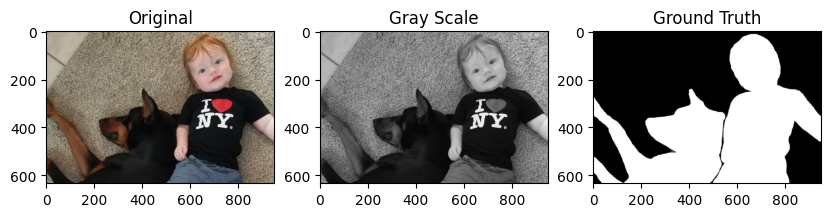

In [4]:
# Mostrar imágenes
plt.figure(figsize=(10, 5))
plt.subplot(231), plt.imshow(img_original), plt.title('Original')
plt.subplot(232), plt.imshow(img_gray_scale, cmap='gray'), plt.title('Gray Scale')
plt.subplot(233), plt.imshow(img_ground_truth, cmap='gray'), plt.title('Ground Truth')
plt.show()

### **Método A: Umbralización con Otsu**



In [5]:
# Convertir a escala de grises
gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

# Aplicar umbralización de Otsu
retval, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

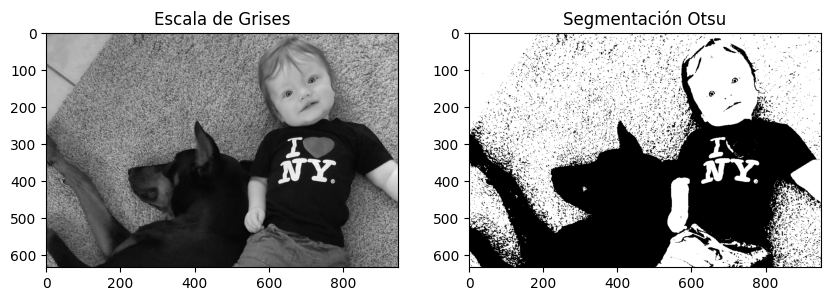

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(img_gray_scale, cmap='gray'), plt.title("Escala de Grises")
plt.subplot(1, 2, 2), plt.imshow(otsu_thresh, cmap='gray'), plt.title('Segmentación Otsu')
plt.show()

### **Método B: Detección de Canny**

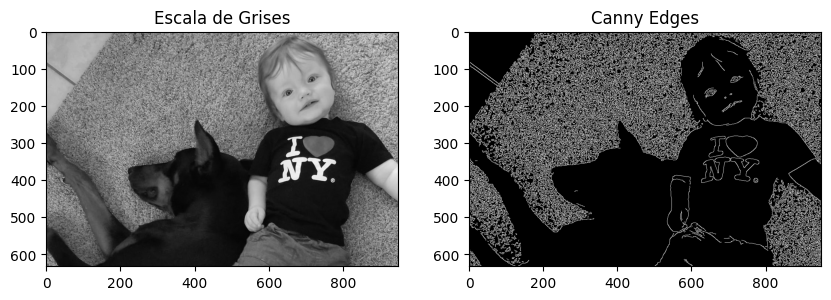

In [7]:
# detecrion Canny
canny_edges = cv2.Canny(img_gray_scale, 100, 200)

# mostrar imagenes
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(img_gray_scale, cmap='gray'), plt.title("Escala de Grises")
plt.subplot(1, 2, 2), plt.imshow(canny_edges, cmap='gray'), plt.title('Canny Edges')
plt.show()

### **Método C: Clustering con K-means**


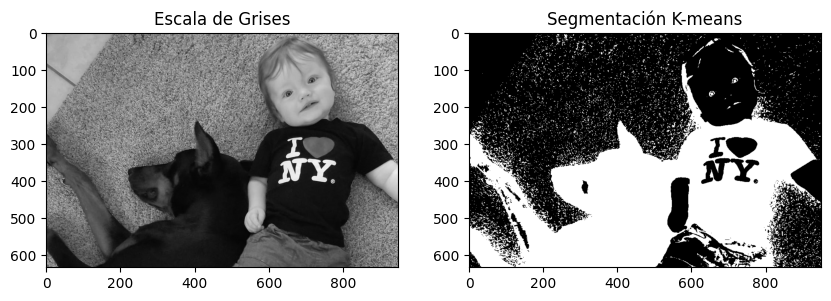

In [8]:
# Redimensionar la imagen para K-means (ancho alto, canales)
pixels = img_original.reshape((-1, 3))

# Aplicar K-means (k=2 para segmentación binaria)
kmeans = KMeans(n_clusters=2, random_state=42).fit(pixels)
segmented = kmeans.labels_.reshape(img_original.shape[:2])

# Convertir a formato binario (0 y 255)
segmented = (segmented * 255).astype(np.uint8)

# Mostrar resultados
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(img_gray_scale, cmap='gray'), plt.title("Escala de Grises")
plt.subplot(1, 2, 2), plt.imshow(segmented, cmap='gray'), plt.title("Segmentación K-means")
plt.show()

### **Método D: Implementación Própria (Region Growing)**

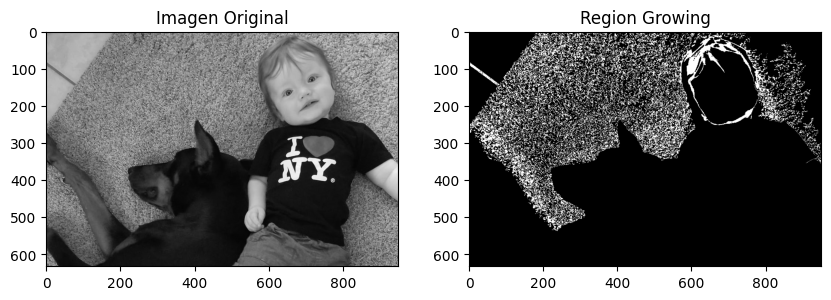

In [9]:
def region_growing(imagen_gris, semilla, umbral=10):

    vecinos = [
        (-4,-2), (-4,-1), (-4, 0), (-4, 1), (-4, 2),
        (-3,-2), (-3,-1), (-3, 0), (-3, 1), (-3, 2),
        (-2,-2), (-2,-1), (-2, 0), (-2, 1), (-2, 2),
        (-1,-2), (-1,-1), (-1, 0), (-1, 1), (-1, 2),
        ( 0,-2), (0, -1),          ( 0, 1), ( 0, 2),
        ( 1,-2), (1, -1), (1,  0), ( 1, 1), ( 1, 2),
        ( 2,-2), (2, -1), (2,  0), ( 2, 1), ( 2, 2),
        ( 3,-2), (3, -1), (3,  0), ( 3, 1), ( 3, 2),
        ( 4,-2), (4, -1), (4,  0), ( 4, 1), ( 4, 2),
    ]
    # Inicializar máscara y cola de píxeles por procesar
    mascara = np.zeros_like(imagen_gris)
    y, x = semilla
    valor_semilla = imagen_gris[y, x]
    cola = deque([(y, x)])
    mascara[y, x] = 255

    while cola:
        y, x = cola.popleft()

        for dy, dx in vecinos:
            ny, nx = y + dy, x + dx

            # Verificar límites de la imagen y si el píxel no ha sido visitado
            if (0 <= ny < imagen_gris.shape[0] and
                0 <= nx < imagen_gris.shape[1] and
                mascara[ny, nx] == 0):

                # Si la intensidad es similar a la semilla, agregar a la región
                if abs(int(imagen_gris[ny, nx]) - int(valor_semilla)) <= umbral:
                    mascara[ny, nx] = 255
                    cola.append((ny, nx))

    return mascara

# Seleccionar semilla (ejemplo: píxel en el centro)
h, w = img_gray_scale.shape
seed = (h // 2, w // 2)

# Aplicar crecimiento de regiones
img_region_growing = region_growing(img_gray_scale, seed, umbral=15)

# Mostrar resultados
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img_gray_scale, cmap='gray'), plt.title('Imagen Original')
plt.subplot(122), plt.imshow(img_region_growing, cmap='gray'), plt.title('Region Growing')
plt.show()

### **E) Umbral Adaptativo (implementación propria)**

Este método realiza una segmentación adaptativa calculando un umbral local para cada píxel. Para ello, se considera una ventana (por ejemplo, 21x21) alrededor de cada píxel, se calcula la media de esa ventana, y se resta un valor constante (offset). Si el valor del píxel es mayor que ese umbral local, se considera parte del objeto (255), en caso contrario, se asigna a fondo (0).

Esta técnica es útil para imágenes con iluminación no uniforme.

Se aplica la función de umbralización adaptativa a la imagen en escala de grises. Se usa una ventana de 21x21 y un offset de 10 para ajustar la sensibilidad del umbral. Esto genera una imagen binaria donde las regiones más brillantes que su entorno se destacan.

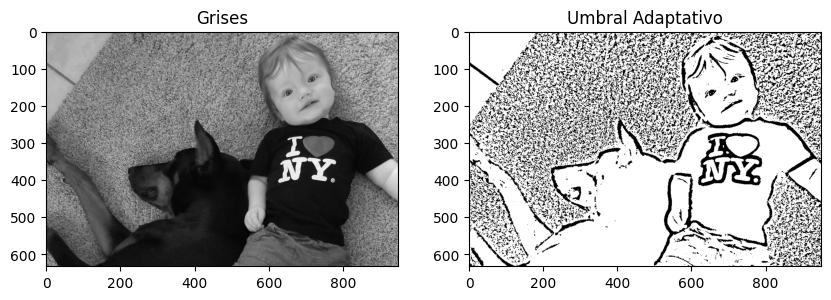

In [10]:
def umbral_adaptativo_manual(img_gray, window_size=15, offset=10):
    # Crear imagen de salida del mismo tamaño, inicializada en ceros
    img_out = np.zeros_like(img_gray)

    # Calcular el padding necesario para aplicar la ventana centrada
    pad = window_size // 2

    # Rellenar bordes con reflexión para evitar problemas en los bordes
    padded = np.pad(img_gray, pad, mode='reflect')

    # Recorrer cada píxel de la imagen
    for y in range(img_gray.shape[0]):
        for x in range(img_gray.shape[1]):
            # Extraer la ventana local centrada en (x, y)
            window = padded[y:y+window_size, x:x+window_size]

            # Calcular el umbral local como la media de la ventana menos el offset
            local_thresh = np.mean(window) - offset

            # Asignar valor binario en función del umbral local
            img_out[y, x] = 255 if img_gray[y, x] > local_thresh else 0

    return img_out


umbral_manual = umbral_adaptativo_manual(img_gray_scale, window_size=21, offset=10)

# Mostrar resultados visualmente para comparar con la imagen original en escala de grises
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(img_gray_scale, cmap='gray'), plt.title('Grises')
plt.subplot(1, 2, 2), plt.imshow(umbral_manual, cmap='gray'), plt.title('Umbral Adaptativo')
plt.show()

---
## **3. Evaluación Cuantitativa**

Compararemos las segmentaciones con el *ground truth* usando métricas como:

- **Índice de Jaccard (IoU)** → Mide superposición entre segmentaciones.
- **Adjusted Rand Index (ARI)** → Evalúa similitud en agrupamientos.

In [11]:
# Evaluación para Otsu
iou_otsu = jaccard_score(img_ground_truth.flatten()//255, otsu_thresh.flatten()//255)
ari_otsu = adjusted_rand_score(img_ground_truth.flatten()//255, otsu_thresh.flatten()//255)

# Evaluación para Canny
iou_canny = jaccard_score(img_ground_truth.flatten()//255, canny_edges.flatten()//255)
ari_canny = adjusted_rand_score(img_ground_truth.flatten()//255, canny_edges.flatten()//255)

# Evaluación para K-means
iou_kmeans = jaccard_score(img_ground_truth.flatten()//255, segmented.flatten()//255)
ari_kmeans = adjusted_rand_score(img_ground_truth.flatten()//255, segmented.flatten()//255)

# Evaluación para Region Growth
iou_region_growth = jaccard_score(img_ground_truth.flatten()//255, img_region_growing.flatten()//255)
ari_region_growth = adjusted_rand_score(img_ground_truth.flatten()//255, img_region_growing.flatten()//255)

# Evaluación para Umbral Adaptativo Manual
iou_adapt = jaccard_score(img_ground_truth.flatten()//255, umbral_manual.flatten()//255)
ari_adapt = adjusted_rand_score(img_ground_truth.flatten()//255, umbral_manual.flatten()//255)

# Resultados
print(f"Otsu: IoU={iou_otsu:.3f}, ARI={ari_otsu:.3f}")
print(f"Canny: IoU={iou_canny:.3f}, ARI={ari_canny:.3f}")
print(f"K-means: IoU={iou_kmeans:.3f}, ARI={ari_kmeans:.3f}")
print(f"Region Growth: IoU={iou_region_growth:.3f}, ARI={ari_region_growth:.3f}")
print(f"Umbral Adaptativo Manual: IoU={iou_adapt:.3f}, ARI={ari_adapt:.3f}")

Otsu: IoU=0.125, ARI=0.373
Canny: IoU=0.015, ARI=0.042
K-means: IoU=0.622, ARI=0.365
Region Growth: IoU=0.020, ARI=0.011
Umbral Adaptativo Manual: IoU=0.465, ARI=0.008


---

## **4. Resultados y Discusión**

| Método       | IoU   | ARI   | Observaciones |
|--------------|-------|-------|---------------|
| Otsu    | 0.125 | 0.373 | Funciona mejor en imágenes con alto contraste. Es más eficiente en imágenes con distribución bimodal de intensidades.|
| Canny   | 0.015 | 0.042 | Funciona bien en imágenes con variaciones de iluminación. |
| K-means  | 0.622 | 0.365 | Más flexible pero depende de la inicialización. Puede adaptarse mejor a imágenes con múltiples colores, pero requiere ajuste de k |
| Region Growth | 0.020 | 0.011 | Ideal para imágenes donde los objetos tienen una textura o intensidad homogénea. |
| Umbral Adaptativo | 0.465 | 0.008 |Buena alternativa cuando la imagen tiene variaciones de iluminación.
.

En este estudio, considerando que la imagen de Ground Truth no tiene los detalles de los objetos en la imagen utilizada, la técnica K-means presentó el mejor resultado.

Sin embargo, valorando visualmente los resultados, el método de Umbral Adaptativo Manual también generó una segmentación bastante aceptable, especialmente en regiones con iluminación desigual donde Otsu no logra un buen desempeño.

Esto sugiere que, si bien el IoU y el ARI son útiles para evaluar el rendimiento de los métodos, la percepción visual del resultado también debe considerarse, particularmente cuando el Ground Truth es limitado o hecho a mano.

### **Dificuldade con Ground Truth**

Una dificultad para realizar este trabajo fue encontrar un ejemplo de Ground Truth para realizar el experimento. La solución fue crear una imagen Ground Truth a mano, con un editor de imágenes. Aunque la imagen generada puede ser objeto de críticas, fue suficiente para los fines didácticos de este experimento.

### **Dificuldad con Implementación de Region Growth**

Otra dificultad fue crear nuestra propia implementación para demostrar un método clásico, como el método de crecimiento regional. El primer intento utilizó 4 vecinos y el resultado fue solo un pequeño punto en el centro de la imagen. Con 8 vecinos se logró un mejor resultado. Luego, se probaron otras cantidades con mejores resultados por cada adición de vecinos. Pero el costo de procesamiento aumenta cada vez que se agregan más vecinos. Así que el experimento finalizó y podemos concluir que una implementación básica de este método requiere una buena cantidad de vecinos para obtener resultados aceptables. Sería necesario añadir otros recursos a la implementación para un resultado más satisfactorio.

### **Dificultad con Umbral Adaptativo**
El método de Umbralización Adaptativa también fue implementado completamente desde cero. Este enfoque demostró ser especialmente útil en imágenes con iluminación no uniforme, donde un umbral global como el de Otsu falla. La lógica fue desarrollada sin funciones empaquetadas, utilizando solo operaciones básicas con NumPy. Ofreció resultados visualmente coherentes con los objetos reales de la imagen, lo cual valida su utilidad como implementación propia.

### **Conclusión**

Al final, se logró el objetivo de experimentar con diferentes técnicas de segmentación y demostrar su aplicabilidad sobre un caso real. Se compararon métodos automáticos (como Otsu, Canny y K-means) con dos implementaciones propias: Region Growing y Umbral Adaptativo

La implementación de un método clásico, al ser muy básico, suele ser un desafío y no proporciona resultados satisfactorios. Es más interesante utilizar, en general, soluciones conocidas y utilizadas en el mercado.